In [1]:
# Real life data

import logging
import threading
import itertools
import json
import os
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func

from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

#### Train a 2-layered LSTM in Watson Machine Learning

 
Telemanom ([Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf) - 2018


Let's find out first what ML libraries are supported by WML.


### Basic Definitions

Forecast 24 data points from a sequence length of 200

In [7]:

n_predictions = 24
n_sequence_length = 200

### Load data

In [36]:
# load data
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)

### Build features

In [59]:
# build features

def addDailyTimeFeatures(df):
    df['hour'] = df.index.hour / 10
    #df['day'] = df.index.dayofyear
    #df['week'] = df.index.weekofyear
    return df

def addConsumptionLagDay(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(days=1)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_1dayago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLag2Days(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(days=2)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_2daysago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLagHour(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(hours=1)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_1hourago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLag2Hours(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(hours=2)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_2hoursago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def fixBlueMonday(df):
    df_blue_monday = df[(df.index.weekday != 0) | (df.index.hour != 9)].\
                        resample('1H').interpolate()
    return df_blue_monday


#featureList = ['KW','TEMP_AIR','UMIDADE_REL']
featureList = ['KW','TEMP_AIR']
stdscal = StandardScaler()
np_input2 = stdscal.fit_transform(df_input[featureList])

df_input2 = pd.DataFrame(np_input2, columns=featureList, index=df_input.index)

df_input2 = fixBlueMonday(df_input2)
df_input2 = addConsumptionLagDay(df_input2)
df_input2 = addConsumptionLag2Days(df_input2)
df_input2 = addConsumptionLagHour(df_input2)
df_input2 = addConsumptionLag2Hours(df_input2)


df_input2 = addDailyTimeFeatures(df_input2)


In [60]:
df_input2.head(4)

,KW,TEMP_AIR,KW_1dayago,KW_2daysago,KW_1hourago,KW_2hoursago,hour
timestamp,,,,,,,
2019-09-18 03:00:00,0.797056,0.498175,0.742610,0.041041,0.797056,0.807945,0.3
2019-09-18 04:00:00,0.807945,0.498175,0.633719,-0.189186,0.797056,0.797056,0.4
2019-09-18 05:00:00,0.709943,0.658531,0.611941,-0.419412,0.807945,0.797056,0.5
2019-09-18 06:00:00,0.775277,0.681439,0.699054,-0.649639,0.709943,0.807945,0.6


### Build Training and Test data

In [61]:
def shape_data(arr, shuffle=False):
    data = []
    for i in range(len(arr) - n_sequence_length - n_predictions):
        data.append(arr[i:i + n_sequence_length + n_predictions])
        
    data = np.array(data)
    # leave that to Keras model.fit
    #if shuffle:
    #    np.random.shuffle(data)
    X = data[:, :-n_predictions, :]
    y = data[:, -n_predictions:, 0]      
    return X,y


X_train,y_train = shape_data(df_input2[0:7000].values, shuffle=True)
X_test, y_test = shape_data(df_input2[7000:].values, shuffle=False)

In [62]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((6776, 200, 7), (6776, 24), (1146, 200, 7), (1146, 24))

### Instantiate model

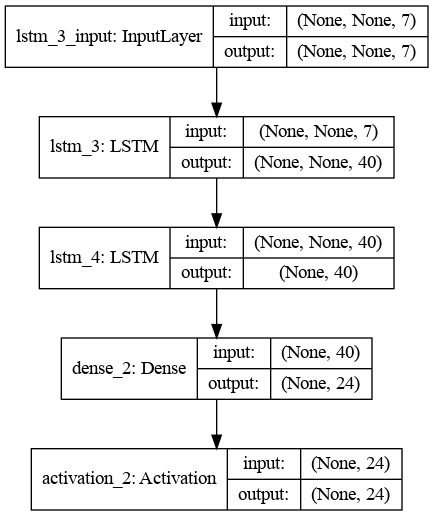

In [63]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import MeanSquaredError,MeanAbsoluteError
from keras.utils.vis_utils import plot_model


n_features = X_train.shape[2]


model_metric = MeanSquaredError()

model = Sequential()

model.add(LSTM(40, 
               input_shape=(None, n_features),
               return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(40, 
               dropout=0.1,
               return_sequences=False))
#model.add(Dropout(0.1))
model.add(Dense(n_predictions))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=[model_metric])


plot_model(model.model, show_shapes=True, show_layer_names=True)

In [64]:
cbs = [History(), EarlyStopping(monitor='val_loss', patience=3, min_delta=0.003, verbose=1)]
history = model.fit(X_train, y_train, batch_size=64, epochs=17, validation_split=0.2, 
                    shuffle=True, callbacks=cbs, verbose=True)


Train on 5420 samples, validate on 1356 samples
Epoch 1/17
5420/5420 [==============================] - 13s 2ms/step - loss: 0.7038 - mean_squared_error: 0.7038 - val_loss: 0.5482 - val_mean_squared_error: 0.5482
Epoch 2/17
5420/5420 [==============================] - 13s 2ms/step - loss: 0.4164 - mean_squared_error: 0.4164 - val_loss: 0.5656 - val_mean_squared_error: 0.5656
Epoch 3/17
5420/5420 [==============================] - 13s 2ms/step - loss: 0.3716 - mean_squared_error: 0.3716 - val_loss: 0.4428 - val_mean_squared_error: 0.4428
Epoch 4/17
5420/5420 [==============================] - 14s 3ms/step - loss: 0.3380 - mean_squared_error: 0.3380 - val_loss: 0.5120 - val_mean_squared_error: 0.5120
Epoch 5/17
5420/5420 [==============================] - 15s 3ms/step - loss: 0.3122 - mean_squared_error: 0.3122 - val_loss: 0.2942 - val_mean_squared_error: 0.2942
Epoch 6/17
5420/5420 [==============================] - 18s 3ms/step - loss: 0.2841 - mean_squared_error: 0.2841 - val_loss: 0.

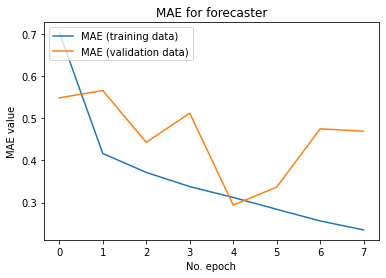

In [65]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for forecaster')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [66]:
model.evaluate(X_test, y_test)

1146/1146 [==============================] - 1s 599us/step


[0.5114796920492595, 0.5114796757698059]

In [67]:
#model.evaluate(X_train, y_train)
X_train.shape

(6776, 200, 7)

In [68]:
X_train[-24:-1].shape

(23, 200, 7)

In [69]:
pred = model.predict(X_train[-2:-1])

In [70]:
act = y_train[-2:-1]

In [71]:
act = act.reshape(-1,1)
pred = pred.reshape(-1,1)

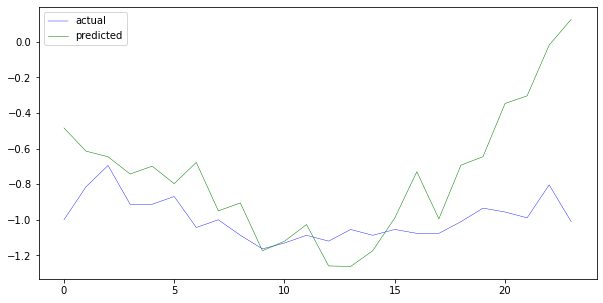

In [72]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()


#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>